Image Captioning is the process of generating a textual description for given images. It has been a very important and fundamental task in the Deep Learning domain. Image captioning has a huge amount of application. NVIDIA is using image captioning technologies to create an application to help people who have low or no eyesight.

Image captioning can be regarded as an end-to-end Sequence to Sequence problem, as it converts images, which is regarded as a sequence of pixels to a sequence of words. For this purpose, we need to process both the language or statements and the images. For the Language part, we use recurrent Neural Networks and for the Image part, we use Convolutional Neural Networks to obtain the feature vectors respectively.

[The paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7505636) that initally inspired out work. Later its methods were overpowered by other papers which were also linked, but out of loyalty we decided to link the first one as well.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the datasets

We will use the [TextCaps dataset](https://textvqa.org/textcaps) and the [MS COCO dataset](https://cocodataset.org/#download) to train our model. The TextCap dataset contains over `28,000` images and the COCO has `123,287` images. Each of which has at least 5 different caption annotations. The code below downloads and extracts the datasets automatically.

Both datasets have training, validation and test sets. But as for the current moment we use only the training set from each. Download, combine them, and take 20% from the collected data to use during validation.

In [ ]:
# Download caption annotation files for both datasets
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_tc = tf.keras.utils.get_file('captions',
                                           cache_subdir=os.path.abspath('.'),
                                           origin = 'https://dl.fbaipublicfiles.com/textvqa/data/textcaps/TextCaps_0.1_train.json')
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_tc)
  annotation_file2 = os.path.dirname(annotation_zip)

  os.remove(annotation_zip)

# Download the MS COCO image files
image_folder = '/train2021/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip_coco = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH_COCO = os.path.dirname(image_zip_coco) + image_folder
  os.remove(image_zip_coco)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 325s 0us/step


We first download the COCO dataset. Delete its zip file to free up space. And then proceed to download the TextCaps images.

TextCaps dataset demands around 6.7 GB and the MS COCO - around 20 GB.

In [ ]:
# Download the TextCaps image files
image_zip = tf.keras.utils.get_file('train2020.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://dl.fbaipublicfiles.com/textvqa/images/train_val_images.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)

7072301056/7072297970 [==============================] - 252s 0us/step


In [ ]:
with open('/content/annotations/captions_train2014.json', 'r') as f:
    annotations_coco = json.load(f)

In [ ]:
with open('/content/captions', 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['data']:
  image_path = "/content/train_images/" + val['image_id'] + '.jpg'
  captions = val['reference_strs']
  for cap in captions:
    caption = f"<start> {cap} <end>"
    image_path_to_caption[image_path].append(caption)

In [ ]:
for val in annotations_coco['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = "/content/train2014/" + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

Take random 6000 images and their corresponding captions to train the model. This does more poorly considering accuracy but is faster. Later this code block will not be executed so that all of the data is used and a finer model is obtained.

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:6000]

print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
print(len(img_name_vector))

54929


Sanity check's are good for the health.

<start> A two story bus with advertisement for Love Rosie, the movie. <end>


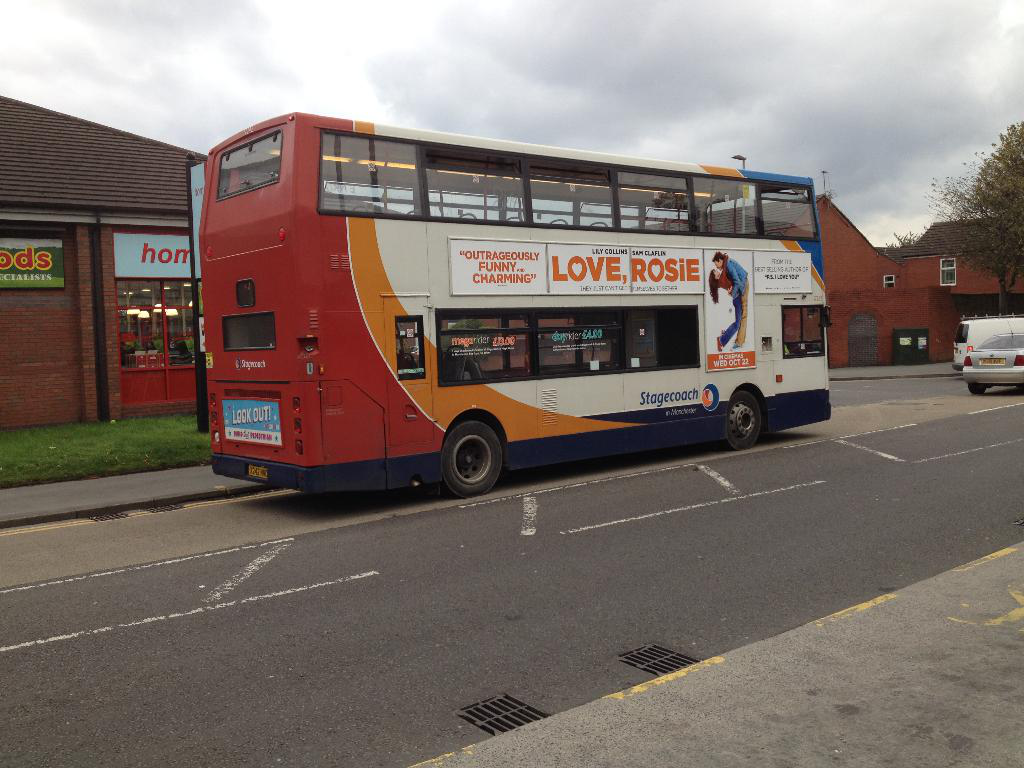

In [ ]:
print(train_captions[1212])
Image.open(img_name_vector[1212])

## Preprocess the images using Xception

Next, we will use Xception (which is pretrained on ImageNet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into Xception's expected format by:
* Resizing the image to 299px by 299px
* Preprocess the images using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train Xception.

`Xception` (Extream Inception) has the same number of parameters as Inception V3 but still slightly outperforms the latter on the ImageNet dataset, and significantly outperforms the same on larger image classification datasets.

The Xception architecture has `36 convolutional layers` forming the feature extraction base of the network. The 36 convolutional layers are structured into
14 modules, all of which have `linear residual connections around them`, except for the first and last modules.

In short, the [Xception architecture](https://arxiv.org/pdf/1610.02357.pdf) is a linear stack of
depthwise separable convolution layers with residual connections.

The `residual connections` are used to allow gradients to flow through the network directly, without passing through non-linear activation functions. This is to address the vanishing/exploding gradient problem.

The `depthwise separable convolution` is the pointwise convolution followed by a depthwise convolution. Pointwise convolution is the 1×1 convolution to change the dimension. Depthwise convolution is the channel-wise n×n spatial convolution. In the Inception model first is the depthwise conv followed by the pointwise conv. This is not to be much of a concern because when it is used in stacked setting, only small differences appeared at the beginning and at the end of all the chained modules.

What is to be noted as a difference between the Inception and the Xception models is the non-linearity. With the former, there is a non-linearity after the first operation in the depthwise separable conv. While in Xception there is no intermediate ReLU. The Xception without any intermediate activation has the highest accuracy.

[Here](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568) we precent graphs of `the modified depthwise separable convolution with different activation units` and `Xception: with and without non-residual connections`.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

## Initialize Xception and load the pretrained weights

Now we will create a `tf.keras model` where the output layer is the last convolutional layer in the Xception architecture. The shape of the output of this layer is ```10x10x2048```. We use the last convolutional layer because we are using attention. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.

We give a false task of image classification to the CNN. In reality we are interested not in the classification abilities of our CNN but in the embeddings/weights the model learns. The last convolutional layer of the CNN is the part which extracts the (highest level) features and nuances out of our image.

In [ ]:
image_model = tf.keras.applications.xception.Xception(include_top = False,
                                                      weights = 'imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

83689472/83683744 [==============================] - 1s 0us/step


## Caching the features extracted from Xception


We will pre-process each image with Xception and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 10 \* 10 \* 2048 floats per image.

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Play around with batch_size according to the system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image,
                                  num_parallel_calls = tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, we will tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data.
* Next, we will limit the vocabulary size to the top 10,000 words. We will replace all other words with the token "UNK" (unknown).
* We then create word-to-index and index-to-word mappings.
* Finally, we pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = "<unk>",
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If we do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                           padding = 'post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

The plan is to use the entirety of the training set - union of the COCO and Caps training sets, for training our model. And for the test part to use the test sets provided by the used datasets. For the current moment, we are taking 20% of the training set to use for testing. If this is left at that, then resource difficulties arrised.


In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

## Create a tf.data dataset for training


Our images and captions are ready! Next, we create a `tf.data` dataset to use for training your model, because everything must be a tensorflow object for things to run smoothly.

In [ ]:
# Play around with these parameters according to the system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000    # representing the number of elements from the dataset from which the new dataset will sample
embedding_dim = 512   # the size of the embedding/feature vector we get from Xception; the size of the vector we give to the Encoder
units = 512   # dimensionality of the GRU/LSTM output space
vocab_size = top_k + 1    # top_k is the number of words we take from the dictonary to build new captions; +1 <unk>
num_steps = len(img_name_train) // BATCH_SIZE   # number of images in a single batch

# Shape of the vector extracted from Xception is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8') + '.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func,
                                                             [item1, item2],
                                                             [tf.float32, tf.int32]),
                      num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

## Model

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* We extract the features from the lower convolutional layer of Xception giving us a vector of shape (10, 10, 2048).
* We squash that to a shape of (100, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (GRU used) attends over the image to predict the next word.

The proposed attention framework does not explicitly use object detectors but
instead learns latent alignments from scratch. This allows
our model to go beyond “objectness” and learn to attend to
abstract concepts.

---

The paper referenced above describes two types of attention - "soft" and "hard" - based on whether the attention has access to the entire image or only a patch.

With the `"soft" attention` the alignment weights are learned and placed over all patches of the image. This is when the Bahdanau attention is used (also known as additive attention).

When using `"hard" attention`, only a patch of the image is selected to be attended to. Here one of Luongs' attentions (known as multiplicative) is used - global (looks like the "soft" attention) or local. The local one is a blend between hard and soft attention, an improvement over the hard attention to make it differentiable: the model first predicts a single aligned position for the current target word and a window centered around the source position is then used to compute a context vector.

---

We are using Luong's local attention, for the sole reason that the global one is non-differentiable and the "hard" attention is more computationally expensive given large input.

```ENCODER: CONVOLUTIONAL FEATURES```

Our model takes a single raw image and generates a caption
y encoded as a sequence of 1-of-K encoded words.

We use a convolutional neural network in order to extract a set of feature vectors which we refer to as `annotation vectors`. The extractor, Xception,   produces L vectors, each of which is a D-dimensional representation corresponding to a part of the image.

In order to obtain a correspondence between the feature vectors and portions of the 2-D image, we use a fully connected layer and a dropout with rate 0.5.

``` DECODER: LONG SHORT-TERM MEMORY NETWORK```

The context vector `zˆt` is a dynamic representation of the relevant part of the image input at time `t`, i.e the part of the image we are currently interested in. We define a mechanism `φ` that computes `zˆt`
from the annotation vectors `a_i`, corresponding
to the features extracted at different image locations.

For each location `i`, the mechanism generates a positive weight `α_i` which can be interpreted either as the probability that location `i` is the right place to focus for producing the next word (the “hard” but stochastic attention mechanism), or as the relative importance to give to location `i` in blending the `a_i`’s together.

We note that the hidden state varies as the output RNN advances in its output sequence: “where” the network looks next depends on the sequence of words that has already been generated.

In Luong attention we get the decoder hidden state at time t. Then calculate  attention scores and from that get the context vector which will be concatenated with hidden state of the decoder and then predict.

But in the Bahdanau, at time t we consider about t-1 hidden states of the decoder. Then we calculate alignment and context vectors as above. But then we concatenate this context with hidden state of the decoder at t-1. So before the softmax this concatenated vector goes inside a GRU.

When the i-th outcome is obtained, the i-th entry of the Multinoulli random vector X takes value 1, while all other entries take value 0.

`GRU`  

The Gated Recurrent Unit strives to resolve the gradient disappearing problem in the backpropagation that tags along with basic RNN. GRU is a variation on the LSTM (GRU came after the Long Short Term Memory) and the reason is the similar structure and, in a few instances produce similar awesome outputs in case of machine translations.

In the vanishing gradient problem the values of the gradients diminish rapidly as they are back-propagated to previous states and they have smaller and smaller changes on the variables in the states until the change is insignificant and the variables at states a few steps away do not train at all.

One solution to this is to use a gated recurrent unit or a GRU. GRU’s are a more complicated node structure than a base RNN in which the value of the previous state is scored for how important it is in the next state and only as much as is optimal is used to compute the next state.

GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

We start with calculating the `update gate` z_t for time step t. When x_t is plugged into the network unit, it is multiplied by its own weight W(z). The same goes for h_(t-1) which holds the information for the previous t-1 units and is multiplied by its own weight U(z). Both results are added together and a sigmoid activation function is applied to squash the result between 0 and 1.

The update gate helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. That is really powerful because the model can decide to copy all the information from the past and eliminate the risk of vanishing gradient problem.  

The `reset gate` is used from the model to decide how much of the past information to forget. It is calculated the same way as the update gate.

First, we start with the usage of the reset gate. We introduce a new memory content which will use the reset gate to store the relevant information from the past. As the last step, the network needs to calculate h_t — vector which holds information for the current unit and passes it down to the network. In order to do that the update gate is needed. It determines what to collect from the current memory content — h’(t) and what from the previous steps — h_(t-1).

`Luong attention`

It is often referred to as Multiplicative Attention and was built on top of the Attention mechanism proposed by Bahdanau.

The encoder produces a hidden state for each element in the input sequence.

Unlike in Bahdanau Attention, the decoder in Luong Attention uses the RNN in the first step of the decoding process rather than the last. The RNN will take the hidden state produced in the previous time step and the word embedding of the final output from the previous time step to produce a new hidden state which will be used in the subsequent steps.

The decoder hidden state and encoder hidden states are added together first before being passed through a Linear layer. This means that the decoder hidden state and encoder hidden state will not have their individual weight matrix, but a shared one instead, unlike in Bahdanau Attention.After being passed through the Linear layer, a tanh activation function will be applied on the output before being multiplied by a weight matrix to produce the alignment score.

Similar to Bahdanau Attention, the alignment scores are softmaxed so that the weights will be between 0 to 1.

Calculating the context vector is done by multipling the attention weights with the encoder outputs.

In the last step, the context vector we just produced is concatenated with the decoder hidden state we generated in step 2. This combined vector is then passed through a Linear layer which acts as a classifier for us to obtain the probability scores of the next predicted word.

In [ ]:
class LuongAttention(tf.keras.Model):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # hidden state shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # features shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    features_transposed = tf.transpose(features, perm = [0, 2, 1])

    # score shape == (batch_size, max_length, 1)

    #LUONGH Dot-product
    score = tf.transpose(tf.matmul(hidden_with_time_axis, features_transposed),
                         perm = [0, 2, 1])

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis = 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 100, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = LuongAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x],
                  axis = -1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True,
                                                            reduction = 'none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
# calls the training step in a loop on each batch of data, and periodically writes checkpoints to disk
# creates a checkpoint; manages saving/restoring trackable values to disk.
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
# keep the 5 most recent checkpoints
# CheckpointManager manages multiple checkpoints by keeping some and deleting unneeded ones.
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep = 5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* We extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


Teacher forcing is a strategy for training recurrent neural networks that uses ground truth as input, instead of model output from a prior time step as an input. Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network.

A quite nice example of how teacher enforcing works is given in [this article](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).

In [ ]:
# adding this in a separate cell because if we run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size = target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

After the 15th epoch the model starts behaving badly.

In [ ]:
EPOCHS = 15
with tf.device('/device:GPU:0'):
  for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size = 1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val,(img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize = (10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap = 'gray', alpha = 0.6, extent = img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
print(ckpt_manager.checkpoints)  # List the five remaining checkpoints

In [ ]:
#import shutil

#encoder.save("ImageCaptioning6000" )

#shutil.copy('/content/ImageCaptioning6000/saved_model.pb', '/content/gdrive/MyDrive/Colab Notebooks/Save Model')
#shutil.copy('/content/ImageCaptioning6000/keras_metadata.pb', '/content/gdrive/MyDrive/Colab Notebooks/Save Model')
#shutil.copy('/content/ImageCaptioning6000/variables/variables.index', '/content/gdrive/MyDrive/Colab Notebooks/Save Model')
#shutil.copy('/content/ImageCaptioning6000/variables/variables.data-00000-of-00001', '/content/gdrive/MyDrive/Colab Notebooks/Save Model')


## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_url = 'https://picsum.photos/300'
image_extension = "jpg"
image_path = tf.keras.utils.get_file('ll' + image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

# opening the image
Image.open(image_path)